# Diagonal Finder script

#### Written by Amir Guppy

In [1]:
import numpy as np
import random
import pandas as pd
from plotnine import ggplot, aes, geom_tile, theme_classic , scale_fill_gradient, theme, element_text, data, geom_blank, theme_void
from plotnine.ggplot import save_as_pdf_pages
from matplotlib import gridspec
import matplotlib.pyplot as plt
import math

#### Generate sample data from gamma distribution

In [48]:
sample = np.random.gamma(0.7, 15000, [7,16])

#### Display sample data

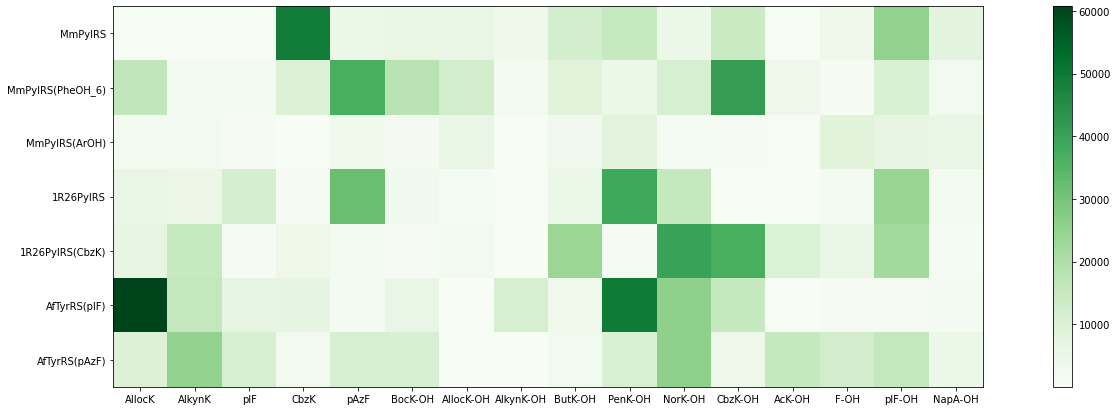

In [49]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(sample, cmap='Greens')
x_label_list = ['AllocK', 'AlkynK', 'pIF', 'CbzK', 'pAzF', 'BocK-OH', 'AllocK-OH', 'AlkynK-OH', 
            'ButK-OH', 'PenK-OH', 'NorK-OH', 'CbzK-OH', 'AcK-OH', 'F-OH', 'pIF-OH', 'NapA-OH']
y_label_list = ['MmPylRS', 'MmPylRS(PheOH_6)', 'MmPylRS(ArOH)', '1R26PylRS', '1R26PylRS(CbzK)', 
           'AfTyrRS(pIF)', 'AfTyrRS(pAzF)'] 
ax.set_xticks([i for i in range(16)])
ax.set_xticklabels(x_label_list)
ax.set_yticks([i for i in range(7)])
ax.set_yticklabels(y_label_list)
fig.set_figheight(7)
fig.set_figwidth(25)
fig.colorbar(img)

### Functions

In [8]:
def is_arr_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if (elem==myarr).all()), False)


def make_diagonal_plots(synth_array, mat_cols, mat_ind):
    plots = []
    for i, a in enumerate(synth_array):
        df = pd.DataFrame(a[0], columns=[mat_cols[i] for i in a[1][1]], index=[mat_ind[j] for j in a[1][0]])
        df_ = df.reset_index()
        df_ = df_.melt(id_vars=['index'])
        df_.columns = ['Synthetase', 'Substrate', 'value']
        plots.append(ggplot(df_, aes(x='Substrate', y='Synthetase', fill='value')) + geom_tile() + scale_fill_gradient(low='white', high='#1d8e5e', limits=[0, 50000]) + theme_classic() + theme(text=element_text(size=10, family='Arial'), axis_text_y = element_text(angle = 90, vjust = 0.5, hjust=1)))
    return plots

        
def diagonal_finder(matrix, col_names, index_names, groups, upper_thresh, lower_thresh, plot=False):
    m = np.array(matrix)
    arrays = []
    for i, row in enumerate(m):
        for group in groups:
            if i in group:
                this_group = group
        for j, val in enumerate(row):
            if val > upper:
                col_low = [k for k, value in enumerate(m[i:, j], i) if value < lower and k not in this_group]
                for index in col_low:
                    for l in range(m.shape[1]):
                        if m[index, l] > upper and m[i, l] < lower:
                            arrays.append([np.array([[m[i, j], m[i, l]], [m[index, j], m[index, l]]]), 
                                          [[i, index], [j, l]]])
    arrays_rev = []
    arrays_ = []
    for a in arrays:
        arrays_rev.append(np.array([[a[0][1, 1], a[0][1, 0]], [a[0][0, 1], a[0][0, 0]]]))
        if not is_arr_in_list(a[0], arrays_rev):
            arrays_.append(a)
    
    unique_subs = set()
    for a in arrays_:
        sub_pair = tuple(a[1][1])
        unique_subs.update([sub_pair])
        
    print(f'There are {len(unique_subs)} substrate pairs across {len(arrays_)} synthetase pairs')
    
    print({f'{mat_cols[unique_sub[0]]} - {mat_cols[unique_sub[1]]}': [f'{mat_ind[a[1][0][0]]} - {mat_ind[a[1][0][1]]}'
                                                           for a in arrays_ if a[1][1] == list(unique_sub)]
     for unique_sub in unique_subs})
    
    if plot:
        plots = make_diagonal_plots(arrays_, col_names, index_names)
        return plots
    
def make_plot_grid(plot_list, export_file_name=None, grid_cols=8):
    
    grid_rows = math.ceil(len(plot_list)/grid_cols)
    
    # Empty plotnine figure to place the subplots on. Needs junk data (for backend "copy" reasons).
    fig = (ggplot()+geom_blank(data=data.diamonds)+theme_void()+theme(figure_size=(grid_cols*3.5, grid_rows*4.5))).draw()

    # Create gridspec for adding subpanels to the blank figure
    gs = gridspec.GridSpec(grid_rows,grid_cols)
    ax = []
    for i in range(grid_rows):
        for j in range(grid_cols):
            ax.append(fig.add_subplot(gs[i,j]))

    # Add subplots to the figure
    for k in range(len(plots)):
        _ = plots[k]._draw_using_figure(fig, [ax[k]])

    fig.show()
    if export_file_name:
        fig.savefig(export_file_name)

#### Set conditions for data

In [6]:
# ncAA substrate names
mat_cols = ['AllocK', 'AlkynK', 'pIF', 'CbzK', 'pAzF', 'BocK-OH', 'AllocK-OH', 'AlkynK-OH', 
            'ButK-OH', 'PenK-OH', 'NorK-OH', 'CbzK-OH', 'AcK-OH', 'F-OH', 'pIF-OH', 'NapA-OH']

# aaRS names
mat_ind = ['MmPylRS', 'MmPylRS(PheOH_6)', 'MmPylRS(ArOH)', '1R26PylRS', '1R26PylRS(CbzK)', 
           'AfTyrRS(pIF)', 'AfTyrRS(pAzF)'] 

# Define groups of aaRS's based on list indices defined above. In this example, MmPylRS (0) and MmPylRS(PheOH_6) (1)
# cannot form a pair, since they are defined in the same group ([0, 1, 2]), while MmPylRS (0) and 1R26PylRS (3) 
# can form a pair, because they are defined in different groups ([0, 1, 2] and [3, 4], respectively)
groups = [[0, 1, 2], [3, 4], [5, 6]] 

# Define upper and lower bounds for pair creation. Here, activity is defined as a value > 10,000, and inactivity as a value
# < 1,000. Units are dependent on the data in the matrix supplied. A pair is created between aaRS1-substrate1 and 
# aaRS2-substrate2 if aaRS1 is active with substrate1 and inactive with substrate2, and aaRS2 is active with substrate2 and 
# inactive with substrate1.
upper = 10000
lower = 1000

### Run function for sample data

Output is N substrate pairs across M synthetase pairs, and a dictionary of the substrate pairs as keys, with the synthetase pairs that can be used for that recoding scheme as values in a list. N substrate pairs means there are N pairs of substrates that could be used in a recoding scheme with the synthetases supplied. M synthetase pairs is the number of synthetase pairs that could be used, such that for each of the N pairs there is at least one synthetase pair, therefore N <= M.

In [50]:
plots = diagonal_finder(sample, mat_cols, mat_ind, groups, upper, lower, plot=True)

There are 12 substrate pairs across 13 synthetase pairs
{'AcK-OH - AlkynK-OH': ['1R26PylRS(CbzK) - AfTyrRS(pIF)'], 'pIF-OH - AlkynK': ['MmPylRS - AfTyrRS(pIF)'], 'pIF-OH - AlkynK-OH': ['1R26PylRS - AfTyrRS(pIF)', '1R26PylRS(CbzK) - AfTyrRS(pIF)'], 'PenK-OH - AcK-OH': ['MmPylRS - 1R26PylRS(CbzK)'], 'pIF-OH - AllocK': ['MmPylRS - AfTyrRS(pIF)'], 'AcK-OH - PenK-OH': ['1R26PylRS(CbzK) - AfTyrRS(pIF)'], 'CbzK-OH - pIF': ['MmPylRS - 1R26PylRS'], 'AllocK-OH - F-OH': ['MmPylRS(PheOH_6) - AfTyrRS(pAzF)'], 'pIF-OH - PenK-OH': ['1R26PylRS(CbzK) - AfTyrRS(pIF)'], 'CbzK - pIF': ['MmPylRS - 1R26PylRS'], 'PenK-OH - AlkynK': ['MmPylRS - 1R26PylRS(CbzK)'], 'pIF-OH - CbzK-OH': ['1R26PylRS - AfTyrRS(pIF)']}


<ipython-input-8-f3a3906cf507>:71: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


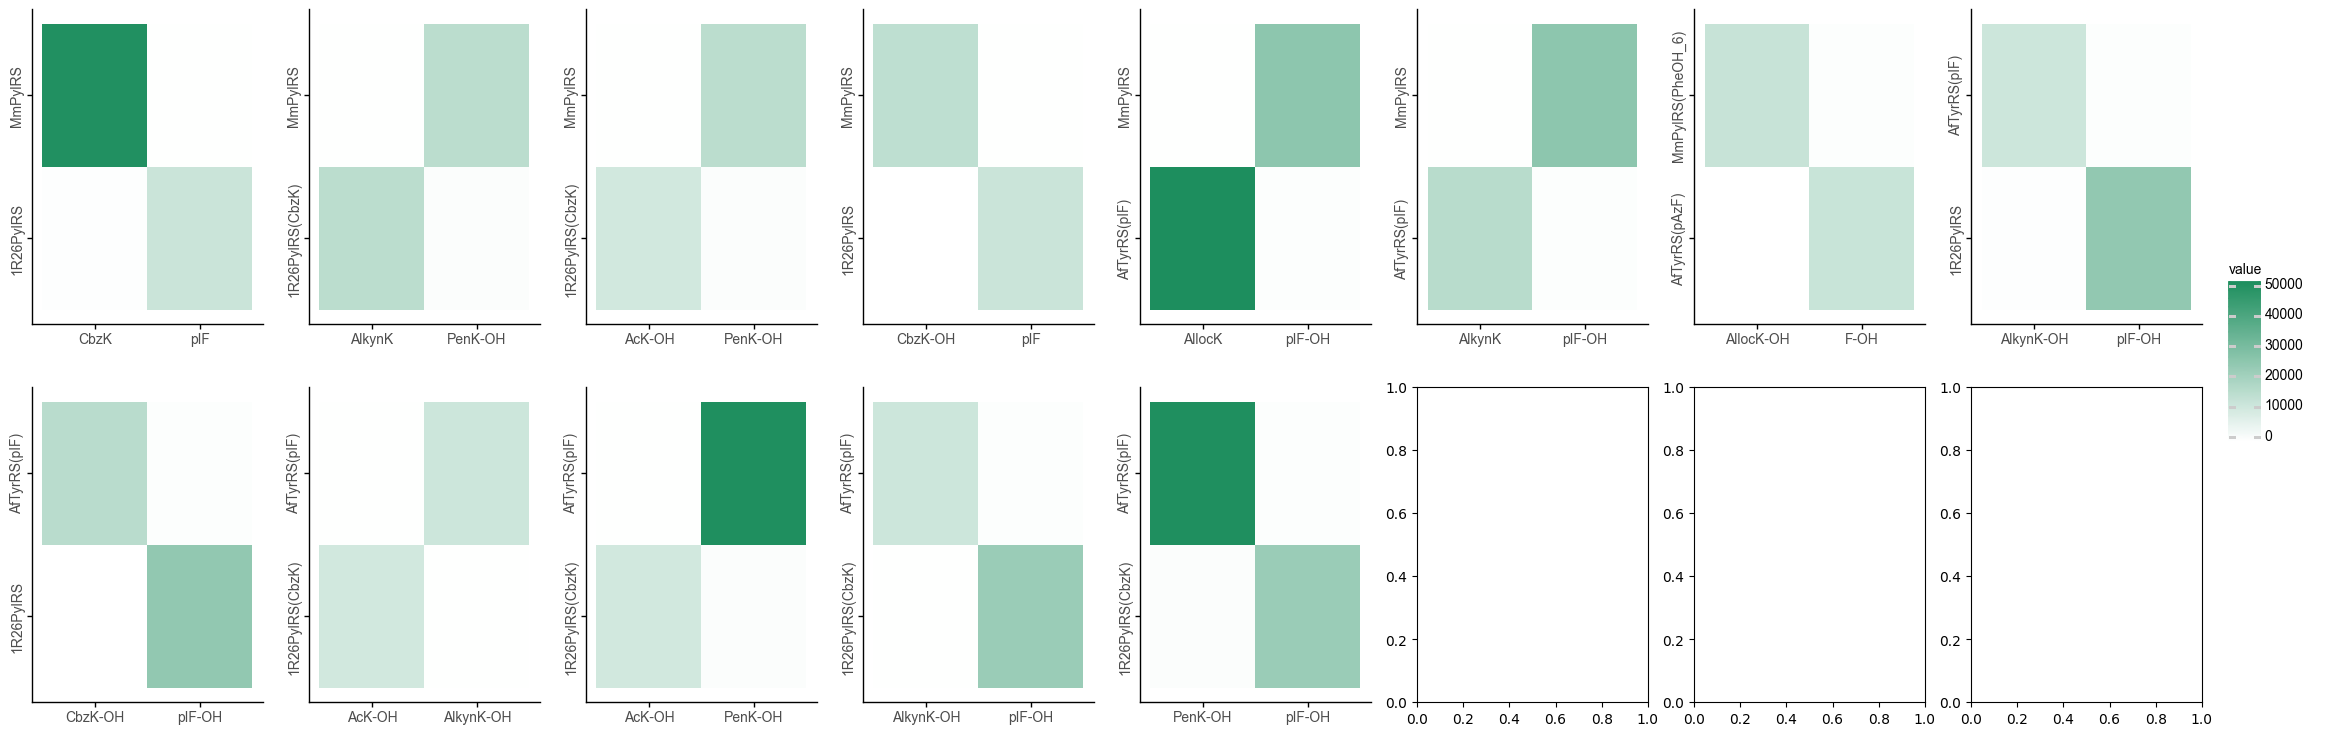

In [51]:
# Can supply file name to save figure
make_plot_grid(plots)